In [34]:
import os
import tqdm
import warnings
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression

from shapely.geometry import Point
import matplotlib.font_manager as fm 
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

from xlrd import open_workbook
from collections import defaultdict

# 전체 데이터 요약
[전체 데이터 요약](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/5942da61-46cd-4833-bdb3-e4cc9647fc6f..png)

## 1. 시청 시작 데이터 : history_data.csv
[시청 시작 데이터](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/2b762359-78b9-470c-9369-5d1b3d9ff06f..png)

In [69]:
df_history = pd.read_csv('data/history_data.csv', index_col=False).drop_duplicates(ignore_index=True)

df_history

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N
...,...,...,...,...,...,...,...,...
899268,33032,20220427155091,20220427155668,MKID003,381,NaN,Y,N
899269,33032,20220427155091,20220427155680,MKID003,381,NaN,Y,N
899270,33032,20220427155839,20220427155810,MKID003,125,NaN,Y,N
899271,33032,20220427155706,20220427155838,MKID003,125,NaN,Y,N


### profile_id

In [71]:
# 결측값 확인

df_history_col = df_history.columns
df_nan = pd.DataFrame(index=['Null', 'Null percentage'], columns=df_history_col)

for c_name in df_history_col:
    df_nan[c_name] = [list(df_history[c_name].isnull()).count(True), 
                    "%.2f%%" % (list(df_history[c_name].isnull()).count(True)*100/len(df_history))]

df_nan

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
Null,0,0,0,0,0,840080,0,0
Null percentage,0.00%,0.00%,0.00%,0.00%,0.00%,93.42%,0.00%,0.00%


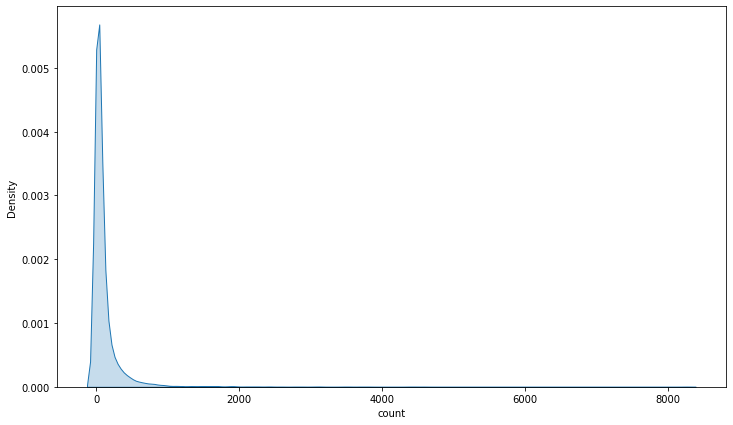

In [72]:
# 기록된 프로필 고유 ID 값 : 총 8311개

g = df_history['profile_id'].groupby(df_history['profile_id']).count() # ID 당 시청 시작 이력 확인

g = g.reset_index(name='count')

fig, ax = plt.subplots(figsize=(12, 7))

sns.kdeplot(x='count', data=g, ax=ax, fill=True)

plt.show()


### ss_id, log_time

In [73]:
ss_id = df_history['ss_id'].unique()
log_time = df_history['log_time'].unique()

print('ss_id length:', len(ss_id))
print('log_time length:', len(log_time))

# Session 저장 시간의 간격의 기준 찾아야 할 듯 -> 2nd file에서 확인

ss_id length: 117749
log_time length: 797725


### payment

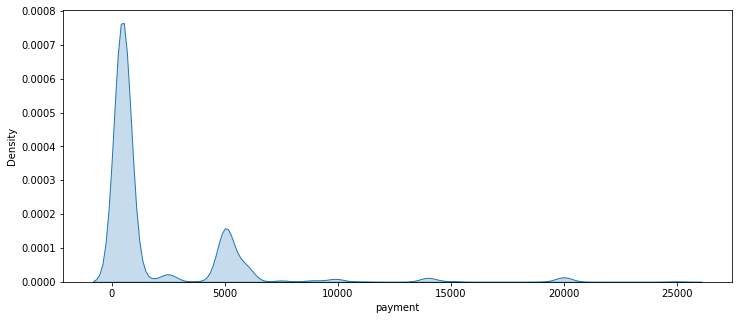

In [74]:
# 지불한 금액 범위 확인
df_history_payment = df_history[df_history['payment'].notnull()]
fig, ax = plt.subplots(1,1, figsize=(12, 5))

sns.kdeplot(x='payment', data=df_history_payment, ax=ax, fill=True)

plt.show()

### continuous_play

In [75]:
df_history_continuous_type = df_history['continuous_play'].unique()

df_history_continuous_type_count = []

for type_ in df_history_continuous_type:
    df_history_continuous_type_count.append(
        list(df_history['continuous_play'] == type_).count(True))
    

for i in range(len(df_history_continuous_type)):
    print(df_history_continuous_type[i], ':', df_history_continuous_type_count[i])



Y : 811869
N : 87404


### short_trailer

In [76]:
df_history_trailer = df_history['short_trailer'].unique()

df_history_trailer_count = []

for type_ in df_history_trailer:
    df_history_trailer_count.append(
        list(df_history['short_trailer'] == type_).count(True))
    

#for i in range(len(df_history_trailer)):
#    print(df_history_trailer[i], ':', df_history_trailer_count[i])

# album ID 와의 연관성

idx = (df_history['short_trailer'] == 'Y')

df_history_album_y = df_history[df_history['short_trailer'] == 'Y']['album_id'].unique()

for id in df_history_album_y:
    idx = (df_history['album_id'] == id)
    print(df_history[idx]['short_trailer'].describe())
    break

# album ID와 short trailer는 1의 상관관계가 있는 것은 아님


count     1062
unique       2
top          Y
freq       956
Name: short_trailer, dtype: object


## 2. 시청 종료 데이터 : watch_e_data.csv
[시청 종료 데이터](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/81a5741f-9481-49ed-8533-1e62d5f9fb50..png)

In [70]:
df_watch = pd.read_csv('data/watch_e_data.csv', index_col=False).drop_duplicates(ignore_index=True)

In [61]:
idx_history = (df_history['profile_id'] == 5950) & (df_history['ss_id'] == 20220416202406) & (df_history['log_time'] == 20220416210631)

print(df_history[idx_history])

idx = (df_watch['profile_id'] == 5950) & (df_watch['ss_id'] == 20220416202406)

df_watch[idx]

        profile_id           ss_id        log_time act_target_dtl  album_id  \
268701        5950  20220416202406  20220416210631        MKID003      4869   
268702        5950  20220416202406  20220416210631        MKID003      4869   

        payment continuous_play short_trailer  
268701      NaN               Y             N  
268702      NaN               Y             N  


,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
239364,5950,20220416202406,20220416205337,MKID049,4869,715,715,1
239365,5950,20220416202406,20220416205337,MKID049,4869,715,715,1
239366,5950,20220416202406,20220416205354,MKID049,11025,15,702,1
239367,5950,20220416202406,20220416205354,MKID049,11025,15,702,1
239368,5950,20220416202406,20220416205401,MKID049,11025,5,702,0
239369,5950,20220416202406,20220416205401,MKID049,11025,5,702,0
239370,5950,20220416202406,20220416205441,MKID049,4869,31,715,0
239371,5950,20220416202406,20220416205441,MKID049,4869,31,715,0
239372,5950,20220416202406,20220416205545,MKID049,4869,18,715,0
239373,5950,20220416202406,20220416205545,MKID049,4869,18,715,0
